### Import Libraries

In [33]:
import os

# Data handling and preprocessing
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Model and evaluation
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Visualization (optional, but helpful for diagnostics)
import matplotlib.pyplot as plt
import seaborn as sns

# Logging for debugging
import logging

# Set up logging (only once)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

### Load the Datasets 

In [34]:
# Define the method you're working on
method = "lasso"  # Change this to "fold_change", "chi_squared", "information_gain", or "lasso"

# File paths
file_paths = {
    "fold_change": "../results/fold_change_results.csv",
    "chi_squared": "../results/chi_squared_features.csv",
    "information_gain": "../results/information_gain_results.csv",
    "rfe_dir": "../results/recursive_feature_elimination/",
    "lasso": "../results/lasso_results.csv",
    "processed_data": "../processed_data/miRNA_stage_subtype.csv"
}

# Function to dynamically load the dataset based on the method
def load_method_data(method, file_paths, num_features=10):
    if method == "fold_change":
        data = pd.read_csv(file_paths["fold_change"])
        top_features = data.nlargest(num_features, "log2_fold_change")["Unnamed: 0"]
    elif method == "chi_squared":
        data = pd.read_csv(file_paths["chi_squared"])
        top_features = data.nlargest(num_features, "Score")["Feature"]
    elif method == "information_gain":
        data = pd.read_csv(file_paths["information_gain"])
        top_features = data.nlargest(num_features, "Info_Gain_General")["Feature"]
    elif method == "rfe":
        rfe_files = [os.path.join(file_paths["rfe_dir"], file) for file in os.listdir(file_paths["rfe_dir"]) if file.endswith('.csv')]
        rfe_combined = pd.concat([pd.read_csv(file) for file in rfe_files]).drop_duplicates()
        feature_counts = rfe_combined['Feature'].value_counts()
        top_features = feature_counts[feature_counts >= 2].index[:num_features]
    elif method == "lasso":
        data = pd.read_csv(file_paths["lasso"])
        top_features = data.nlargest(num_features, "Coefficient")["Feature"]
    else:
        raise ValueError(f"Unknown method: {method}")
    
    logging.info(f"Top {num_features} features selected for {method}: {top_features.tolist()}")
    return top_features.tolist()

# Load processed data
processed_data = pd.read_csv(file_paths["processed_data"])

# Select top features for the chosen method
num_features_to_select = 10  # Change this as needed
top_features = load_method_data(method, file_paths, num_features=num_features_to_select)


### Prepare the Data

In [35]:
def process_features_and_labels(processed_data, selected_features, target_column="stage"):
    """
    Filter processed data for selected features and extract target labels.

    Args:
        processed_data (pd.DataFrame): Data containing features and target variables.
        selected_features (list): List of feature names to filter.
        target_column (str): Name of the target column.

    Returns:
        tuple: Filtered features (pd.DataFrame) and target labels (pd.Series).
    """
    # Verify all selected features exist in the data
    missing_features = [f for f in selected_features if f not in processed_data.columns]
    if missing_features:
        logging.warning(f"Features not found in data: {missing_features}")
        selected_features = [f for f in selected_features if f in processed_data.columns]
    
    # Filter processed data
    expression_values = processed_data[selected_features]
    y = processed_data[target_column]

    # Check for missing values
    if expression_values.isnull().values.any() or y.isnull().values.any():
        logging.warning("Missing values detected in features or labels.")
        print(f"Missing values in features:\n{expression_values.isnull().sum()}")
        print(f"Missing values in labels:\n{y.isnull().sum()}")
        
        # Keep only rows where both features and labels are non-null
        valid_indices = ~(expression_values.isnull().any(axis=1) | y.isnull())
        expression_values = expression_values[valid_indices]
        y = y[valid_indices]

    # Log data info
    logging.info(f"Features shape: {expression_values.shape}")
    logging.info(f"Labels shape: {y.shape}")
    logging.info(f"Class distribution:\n{y.value_counts(normalize=True)}")
    
    # Additional data quality checks
    if len(y.unique()) < 2:
        raise ValueError("Less than 2 classes present in labels after preprocessing")
    
    if expression_values.shape[0] < 10:  # arbitrary minimum
        logging.warning("Very few samples remaining after preprocessing")

    return expression_values, y

# Process features and labels
expression_values, y = process_features_and_labels(processed_data, top_features, target_column="stage")

# Debugging: Check the prepared data
print("\nExpression values sample:")
print(expression_values.head())
print("\nFeature statistics:")
print(expression_values.describe())
print("\nTarget variable distribution:")
print(y.value_counts())
print("\nClass proportions:")
print(y.value_counts(normalize=True))


Expression values sample:
   hsa-mir-1825  hsa-mir-1181  hsa-mir-8066  hsa-mir-187  hsa-mir-185  \
0           0.0      0.000000           0.0     3.694062   102.090453   
1           0.0      0.153599           0.0    26.572554    63.589811   
2           0.0      0.000000           0.0    61.130281    65.787827   
3           0.0      0.280534           0.0     2.524808    76.866387   
4           0.0      0.460051           0.0     7.820865    78.208654   

   hsa-mir-548ak  hsa-mir-6766  hsa-mir-8082  hsa-mir-760  hsa-mir-3922  
0            0.0      0.167912           0.0     0.671648      0.167912  
1            0.0      0.307197           0.0     0.000000      1.228789  
2            0.0      0.000000           0.0     1.164386      1.746579  
3            0.0      0.000000           0.0     0.000000      0.280534  
4            0.0      0.000000           0.0     2.760305      2.070229  

Feature statistics:
       hsa-mir-1825  hsa-mir-1181  hsa-mir-8066  hsa-mir-187  hsa-mir

### SMOTE for balancing the dataset

In [36]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Data validation and preprocessing
print("\nInitial data check:")
print("Top features:", top_features)
print("Number of top features:", len(top_features))

# Validate features
top_features = [feature for feature in top_features if feature in processed_data.columns]
if not top_features:
    raise ValueError("No matching features found in processed data for the selected feature set.")

# Filter and prepare data
expression_values = processed_data[top_features]
print("\nData shapes:")
print("Expression values shape after filtering:", expression_values.shape)
print("Target labels shape:", y.shape)
print("\nClass distribution before SMOTE:\n", y.value_counts())
print("Class proportions before SMOTE:\n", y.value_counts(normalize=True))

# Convert to numeric and handle missing values
expression_values = expression_values.apply(pd.to_numeric, errors='coerce')
original_samples = len(expression_values)
expression_values = expression_values.dropna()
if len(expression_values) < original_samples:
    logging.warning(f"Dropped {original_samples - len(expression_values)} rows with null values")

# Validate shapes
if len(expression_values) != len(y):
    raise ValueError("Mismatch in shapes: Features and labels must have the same number of rows.")

# Scale features before SMOTE
scaler = StandardScaler()
expression_values_scaled = scaler.fit_transform(expression_values)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(expression_values_scaled, y)

# Check SMOTE results
print("\nSMOTE results:")
print("Original dataset shape:", expression_values.shape)
print("Resampled dataset shape:", X_resampled.shape)
print("\nClass distribution after SMOTE:\n", pd.Series(y_resampled).value_counts())
print("Class proportions after SMOTE:\n", pd.Series(y_resampled).value_counts(normalize=True))

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

# Log split information
print("\nTrain-Test Split Information:")
print(f"Training set: {X_train.shape}")
print(f"Testing set: {X_test.shape}")
print("\nTraining set class distribution:")
print(pd.Series(y_train).value_counts())
print("\nTesting set class distribution:")
print(pd.Series(y_test).value_counts())

# Save scaler for later use
scaler_info = {
    'scaler': scaler,
    'feature_names': top_features
}


Initial data check:
Top features: ['hsa-mir-1825', 'hsa-mir-1181', 'hsa-mir-8066', 'hsa-mir-187', 'hsa-mir-185', 'hsa-mir-548ak', 'hsa-mir-6766', 'hsa-mir-8082', 'hsa-mir-760', 'hsa-mir-3922']
Number of top features: 10

Data shapes:
Expression values shape after filtering: (1091, 10)
Target labels shape: (1091,)

Class distribution before SMOTE:
 stage
1    566
2    308
3    175
4     31
0     11
Name: count, dtype: int64
Class proportions before SMOTE:
 stage
1    0.518790
2    0.282310
3    0.160403
4    0.028414
0    0.010082
Name: proportion, dtype: float64

SMOTE results:
Original dataset shape: (1091, 10)
Resampled dataset shape: (2830, 10)

Class distribution after SMOTE:
 stage
1    566
3    566
2    566
4    566
0    566
Name: count, dtype: int64
Class proportions after SMOTE:
 stage
1    0.2
3    0.2
2    0.2
4    0.2
0    0.2
Name: proportion, dtype: float64

Train-Test Split Information:
Training set: (2264, 10)
Testing set: (566, 10)

Training set class distribution:
sta

### Train-Test Split

In [37]:
# Data Preparation Block
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(expression_values, y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, 
    test_size=0.2, 
    stratify=y_resampled, 
    random_state=42
)

### Train the SVM Classifier

In [38]:
# Model Training Block
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train SVM
svm_classifier = SVC(kernel='rbf', class_weight='balanced', random_state=42)
svm_classifier.fit(X_train, y_train)

# Evaluate
y_pred = svm_classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.89      0.68       113
           1       0.35      0.27      0.31       113
           2       0.49      0.19      0.27       113
           3       0.55      0.51      0.53       114
           4       0.56      0.73      0.64       113

    accuracy                           0.52       566
   macro avg       0.50      0.52      0.49       566
weighted avg       0.50      0.52      0.49       566



### Evaluate the Model


-------------------- SVM (lasso) Results --------------------

Accuracy: 0.5194

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.89      0.68       113
           1       0.35      0.27      0.31       113
           2       0.49      0.19      0.27       113
           3       0.55      0.51      0.53       114
           4       0.56      0.73      0.64       113

    accuracy                           0.52       566
   macro avg       0.50      0.52      0.49       566
weighted avg       0.50      0.52      0.49       566


Confusion Matrix:
[[101   2   1   0   9]
 [ 24  31  12  21  25]
 [ 27  28  21  22  15]
 [ 13  20   8  58  15]
 [ 18   7   1   4  83]]

Per-class Accuracy:
Class 0: 0.8938
Class 1: 0.2743
Class 2: 0.1858
Class 3: 0.5088
Class 4: 0.7345
Plot saved as ../results/svm/lasso_evaluation_results.png


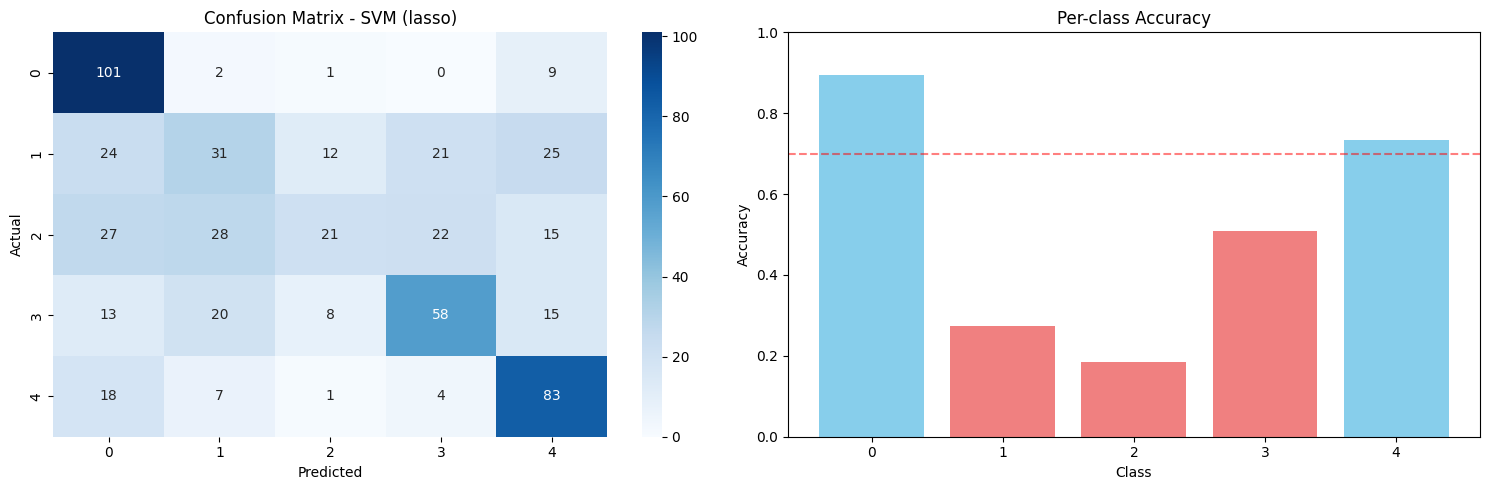

In [39]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import logging

def evaluate_model(y_test, y_pred, model_name="SVM", save_path="evaluation_results.png"):
    """
    Evaluate model performance with multiple metrics and visualizations.
    """
    # Determine class labels
    target_names = [str(cls) for cls in sorted(set(y_test))]
    
    # Calculate basic metrics
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    # Print results
    print(f"\n{'-'*20} {model_name} Results {'-'*20}")
    print(f"\nAccuracy: {accuracy:.4f}")
    
    print("\nClassification Report:")
    report = classification_report(y_test, y_pred, target_names=target_names)
    print(report)
    
    print("\nConfusion Matrix:")
    print(cm)
    
    # Calculate per-class metrics
    per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
    print("\nPer-class Accuracy:")
    for class_name, acc in zip(target_names, per_class_accuracy):
        print(f"Class {class_name}: {acc:.4f}")
    
    # Visualizations
    plt.figure(figsize=(15, 5))
    
    # 1. Confusion Matrix Heatmap
    plt.subplot(121)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    
    # 2. Per-class Accuracy Bar Plot
    plt.subplot(122)
    colors = ['skyblue' if acc >= 0.7 else 'lightcoral' for acc in per_class_accuracy]
    plt.bar(target_names, per_class_accuracy, color=colors)
    plt.axhline(y=0.7, color='red', linestyle='--', alpha=0.5)  # Threshold line
    plt.ylim(0, 1)
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.title('Per-class Accuracy')
    
    plt.tight_layout()
    
    # Save the plot with correct feature selection method
    plt.savefig(save_path)
    print(f"Plot saved as {save_path}")
    
    plt.show()
    
    # Return metrics for later use if needed
    metrics = {
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'classification_report': report,
        'per_class_accuracy': per_class_accuracy
    }
    
    return metrics

# ✅ Corrected usage: Use actual model predictions
save_path = f"../results/svm/{method}_evaluation_results.png"
metrics = evaluate_model(y_test, y_pred, model_name=f"SVM ({method})", save_path=save_path)

# Log results
logging.info(f"Model evaluation completed. Overall accuracy: {metrics['accuracy']:.4f}")

### Metrics


Plotting Confusion Matrix:
Confusion matrix saved to ../results/svm/lasso_evaluation_plots/confusion_matrix.png


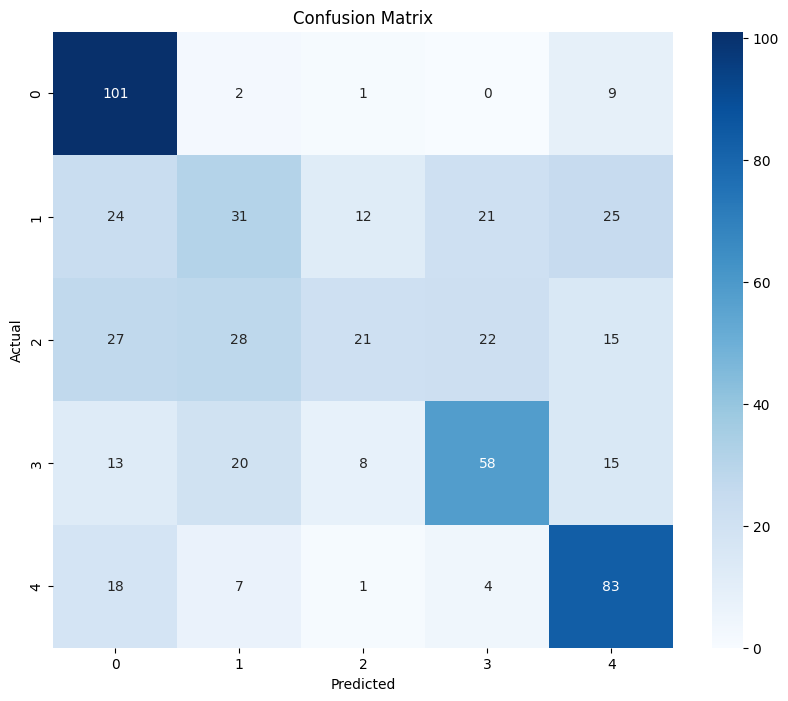


Plotting Metrics Comparison:
Metrics comparison saved to ../results/svm/lasso_evaluation_plots/metrics_comparison.png


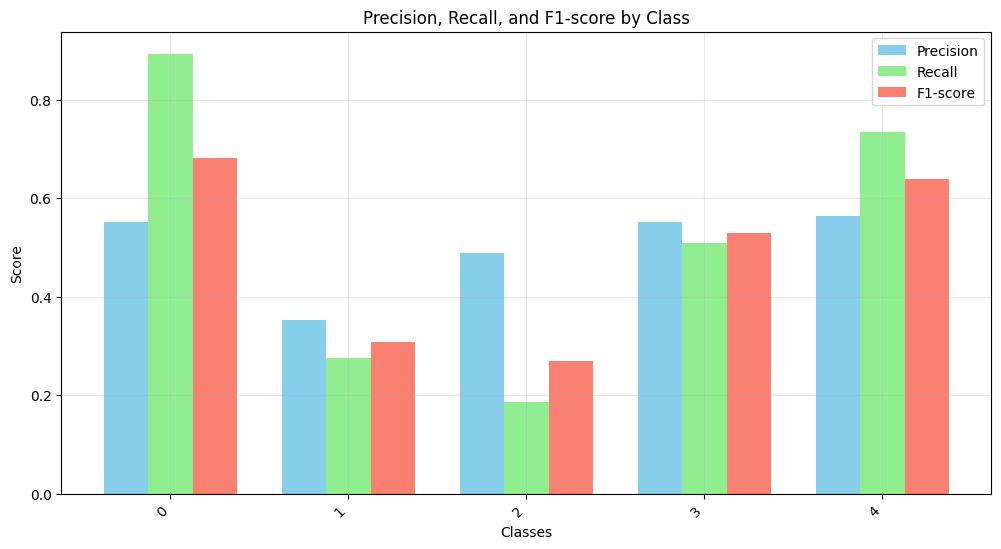


Plotting Metrics Heatmap:
Metrics heatmap saved to ../results/svm/lasso_evaluation_plots/metrics_heatmap.png


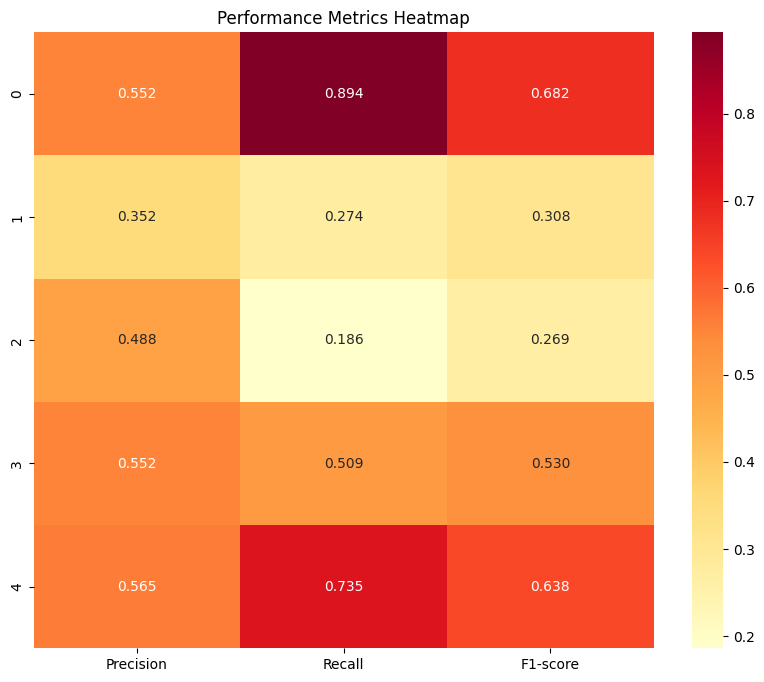

In [40]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Create directory for saving plots
save_dir = f"../results/svm/{method}_evaluation_plots/"
os.makedirs(save_dir, exist_ok=True)

def plot_confusion_matrix(y_test, y_pred, target_names, save_path=None):
    """Plot confusion matrix heatmap and save it"""
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    
    if save_path:
        plt.savefig(save_path)
        print(f"Confusion matrix saved to {save_path}")
    plt.show()

def plot_metrics_comparison(y_test, y_pred, target_names, save_path=None):
    """Plot precision, recall, and F1-score comparison"""
    report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
    
    # Remove accuracy (not per-class)
    if 'accuracy' in report:
        del report['accuracy']
    
    # Extract precision, recall, and F1-score
    metrics_data = {'Precision': [], 'Recall': [], 'F1-score': []}
    for class_name in target_names:
        metrics_data['Precision'].append(report[class_name]['precision'])
        metrics_data['Recall'].append(report[class_name]['recall'])
        metrics_data['F1-score'].append(report[class_name]['f1-score'])
    
    # Plot
    plt.figure(figsize=(12, 6))
    x = np.arange(len(target_names))
    width = 0.25
    
    plt.bar(x - width, metrics_data['Precision'], width, label='Precision', color='skyblue')
    plt.bar(x, metrics_data['Recall'], width, label='Recall', color='lightgreen')
    plt.bar(x + width, metrics_data['F1-score'], width, label='F1-score', color='salmon')
    
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1-score by Class')
    plt.xticks(x, target_names, rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    if save_path:
        plt.savefig(save_path)
        print(f"Metrics comparison saved to {save_path}")
    plt.show()

def plot_metrics_heatmap(y_test, y_pred, target_names, save_path=None):
    """Plot heatmap of metrics for each class"""
    report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
    
    if 'accuracy' in report:
        del report['accuracy']
    
    metrics_df = np.array([
        [report[class_name]['precision'], report[class_name]['recall'], report[class_name]['f1-score']]
        for class_name in target_names
    ])
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(metrics_df, annot=True, fmt='.3f', 
                xticklabels=['Precision', 'Recall', 'F1-score'], 
                yticklabels=target_names, cmap='YlOrRd')
    plt.title('Performance Metrics Heatmap')
    
    if save_path:
        plt.savefig(save_path)
        print(f"Metrics heatmap saved to {save_path}")
    plt.show()

# ✅ Run evaluations and save plots
target_names = [str(cls) for cls in sorted(set(y_test))]

print("\nPlotting Confusion Matrix:")
plot_confusion_matrix(y_test, y_pred, target_names, save_path=os.path.join(save_dir, "confusion_matrix.png"))

print("\nPlotting Metrics Comparison:")
plot_metrics_comparison(y_test, y_pred, target_names, save_path=os.path.join(save_dir, "metrics_comparison.png"))

print("\nPlotting Metrics Heatmap:")
plot_metrics_heatmap(y_test, y_pred, target_names, save_path=os.path.join(save_dir, "metrics_heatmap.png"))

### Save Results

In [41]:
import os
import json
import pandas as pd
import logging
import joblib
from sklearn.metrics import accuracy_score

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Dynamically adjust the method name
method = 'lasso'  # Change as needed

# Ensure results and metadata directory exist
output_dir = f'../results/svm/{method}'
os.makedirs(output_dir, exist_ok=True)

# Convert labels to Pandas Series for consistency
y_test = pd.Series(y_test)
y_pred = pd.Series(y_pred)

# ✅ Function to Save Predictions
def save_results(y_test, y_pred, method, output_dir):
    """
    Save predictions and actual labels to a CSV file.
    """
    results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    output_path = os.path.join(output_dir, f'svm_results_{method}.csv')

    try:
        results.to_csv(output_path, index=False)
        logging.info(f"Results saved successfully to {output_path}")
        print(f"Results saved to {output_path}")
    except Exception as e:
        logging.error(f"Failed to save results: {e}")
        print(f"Error: {e}")

# ✅ Function to Save Experiment Metadata
def save_metadata(metadata, method, output_dir):
    """
    Save experiment metadata to a JSON file.
    """
    metadata_path = os.path.join(output_dir, f'metadata_{method}.json')
    
    try:
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=4)
            logging.info(f"Metadata saved successfully to {metadata_path}")
            print(f"Metadata saved to {metadata_path}")
    except Exception as e:
        logging.error(f"Failed to save metadata: {e}")
        print(f"Error: {e}")

# ✅ Function to Save the Trained Model
def save_model(model, method, output_dir):
    """
    Save the trained SVM model as a .pkl file.
    """
    model_path = os.path.join(output_dir, f'svm_model_{method}.pkl')
    
    try:
        joblib.dump(model, model_path)
        logging.info(f"Model saved successfully to {model_path}")
        print(f"Model saved to {model_path}")
    except Exception as e:
        logging.error(f"Failed to save model: {e}")
        print(f"Error: {e}")

# 🔹 Call Functions with Dynamically Defined Parameters
save_results(y_test, y_pred, method, output_dir)

# Construct Experiment Metadata
metadata = {
    'Method': method,
    'Training Set Size': X_train.shape[0],
    'Test Set Size': X_test.shape[0],
    'Kernel': getattr(svm_classifier, 'kernel', 'Unknown'),
    'Class Weights': getattr(svm_classifier, 'class_weight', 'Unknown'),
    'Accuracy': round(accuracy_score(y_test, y_pred), 4)
}

save_metadata(metadata, method, output_dir)
save_model(svm_classifier, method, output_dir)

Results saved to ../results/svm/lasso/svm_results_lasso.csv
Metadata saved to ../results/svm/lasso/metadata_lasso.json
Model saved to ../results/svm/lasso/svm_model_lasso.pkl
